In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# paths (workspace)
sales_path = "/workspaces/TeamCPH/data/umsatzdaten_gekuerzt.csv"
wetter_path = "/workspaces/TeamCPH/data/wetter.csv"
kiwo_path = "/workspaces/TeamCPH/data/kiwo.csv"
holidays_path = "/workspaces/TeamCPH/data/school_holidays_SH.csv"

# load sales and aggregate to daily total
sales = pd.read_csv(sales_path, parse_dates=["Datum"])
sales_daily = sales.groupby("Datum", as_index=False)["Umsatz"].sum()

# load weather and kieler-week flags
wetter = pd.read_csv(wetter_path, parse_dates=["Datum"])
kiwo = pd.read_csv(kiwo_path, parse_dates=["Datum"])
holidays = pd.read_csv(holidays_path, parse_dates=["Datum"])

# merge: sales <- weather <- kiwo
merged = sales_daily.merge(wetter, on="Datum", how="left")
merged = merged.merge(kiwo, on="Datum", how="left")
merged = merged.merge(holidays, on="Datum", how="left")

# fill missing KielerWoche as 0 (not festival) and sort
merged["KielerWoche"] = merged["KielerWoche"].fillna(0).astype(int)
merged = merged.sort_values("Datum").reset_index(drop=True)

# extract year-month and aggregate
merged["YearMonth"] = merged["Datum"].dt.to_period("M")

# group by month: sum revenue and count KielerWoche days
monthly = merged.groupby("YearMonth").agg({
    "Umsatz": "sum",
    "KielerWoche": "sum"
}).reset_index()

# convert YearMonth back to timestamp for plotting
monthly["YearMonth"] = monthly["YearMonth"].dt.to_timestamp()



# result
print(merged.head())
# optionally save
# merged.to_csv("/workspaces/TeamCPH/merged_daily.csv", index=False)

       Datum       Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0 2013-07-01  1269.249107         6.0     17.8375                 15.0   
1 2013-07-02  1430.008397         3.0     17.3125                 10.0   
2 2013-07-03  1124.274894         7.0     21.0750                  6.0   
3 2013-07-04  1184.309567         7.0     18.8500                  7.0   
4 2013-07-05  1288.023060         5.0     19.9750                 12.0   

   Wettercode  KielerWoche  holiday YearMonth  
0        20.0            0        1   2013-07  
1         NaN            0        1   2013-07  
2        61.0            0        1   2013-07  
3        20.0            0        1   2013-07  
4         NaN            0        1   2013-07  


In [72]:
# translations 
merged.rename(columns={'Datum': 'Date'}, inplace=True)
merged.rename(columns={'Umsatz': 'Revenue'}, inplace=True)
merged.rename(columns={'Bewoelkung': 'CloudCover'}, inplace=True)
merged.rename(columns={'Temperatur': 'Temperature'}, inplace=True)
merged.rename(columns={'Windgeschwindigkeit': 'WindSpeed'}, inplace=True)
merged.rename(columns={'Wettercode': 'WeatherCode'}, inplace=True)
merged.rename(columns={'KielerWoche': 'KielWeek'}, inplace=True)
print(merged)

           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
1814 2018-07-27  1572.847053         0.0      27.5875       16.0          5.0   
1815 2018-07-28  1646.938417         3.0      28.7500       11.0         95.0   
1816 2018-07-29  1750.221545         0.0      24.5500        6.0          NaN   
1817 2018-07-30  1510.458573         6.0      27.7875       10.0         21.0   
1818 2018-07-31  1313.474071         5.0      31.2875       11.0          NaN   

      KielWeek  holiday Yea

In [73]:
# descriptive statistics
import numpy as np

# basic shape and info
print('Shape:', merged.shape)

# basic descriptive statistics for key variables
stats = merged[['Revenue', 'CloudCover','Temperature','WindSpeed']].describe()
print('Descriptive statistics for key variables:')
print(stats)

Shape: (1819, 9)
Descriptive statistics for key variables:
           Revenue   CloudCover  Temperature    WindSpeed
count  1819.000000  1807.000000   1816.00000  1816.000000
mean   1060.910160     4.688434     12.20778    10.996696
std     290.267632     2.650726      7.26073     4.128913
min     525.973832     0.000000     -8.47500     3.000000
25%     850.806263     3.000000      6.37500     8.000000
50%    1001.424738     6.000000     12.04375    10.000000
75%    1226.344892     7.000000     18.12500    13.000000
max    3156.413344     8.000000     31.43750    35.000000


In [74]:
# cleaning the dataset 

# analyse the 'Not a Number' (NaN) values in each column
# the intention is to remove from the dataset rows containing NaN values
nan_per_column = merged.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

# the intention is to remove from the dataset rows containing NaN values
merged_cleaned = merged.dropna(subset=['CloudCover', 'Temperature', 'WindSpeed'], how='any')
print(merged_cleaned)
print('Shape after cleaning:', merged_cleaned.shape)

NaN values in each column:
Date             0
Revenue          0
CloudCover      12
Temperature      3
WindSpeed        3
WeatherCode    459
KielWeek         0
holiday          0
YearMonth        0
dtype: int64
           Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0    2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1    2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2    2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3    2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4    2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
...         ...          ...         ...          ...        ...          ...   
1814 2018-07-27  1572.847053         0.0      27.5875       16.0          5.0   
1815 2018-07-28  1646.938417         3.0      28.7500       11.0         95.0   
1816 2018-07-29  1750.221545         0.0      24.5500       

In [75]:
nan_per_column = merged_cleaned.isnull().sum()
print('NaN values in each column:')
print(nan_per_column)

NaN values in each column:
Date             0
Revenue          0
CloudCover       0
Temperature      0
WindSpeed        0
WeatherCode    447
KielWeek         0
holiday          0
YearMonth        0
dtype: int64


In [76]:
import pandas as pd

# load the wetter.csv file
wetter = pd.read_csv("/workspaces/TeamCPH/data/wetter.csv", parse_dates=["Datum"])

# display first 100 rows
print(wetter.head(100))

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
..        ...         ...         ...                  ...         ...
95 2012-04-05         1.0      5.6375                   10         NaN
96 2012-04-06         7.0      6.2000                   18        61.0
97 2012-04-07         4.0      3.7125                   19         NaN
98 2012-04-08         2.0      5.7500                   10         NaN
99 2012-04-09         8.0      6.5125                   10        58.0

[100 rows x 5 columns]


In [77]:
print(merged_cleaned.head(10))

        Date      Revenue  CloudCover  Temperature  WindSpeed  WeatherCode  \
0 2013-07-01  1269.249107         6.0      17.8375       15.0         20.0   
1 2013-07-02  1430.008397         3.0      17.3125       10.0          NaN   
2 2013-07-03  1124.274894         7.0      21.0750        6.0         61.0   
3 2013-07-04  1184.309567         7.0      18.8500        7.0         20.0   
4 2013-07-05  1288.023060         5.0      19.9750       12.0          NaN   
5 2013-07-06  1540.529898         0.0      18.9625        8.0          NaN   
6 2013-07-07  1532.372927         0.0      21.3750        9.0          NaN   
7 2013-07-08  1203.921695         0.0      22.7250       10.0          5.0   
8 2013-07-09  1385.112329         0.0      23.2750        8.0          NaN   
9 2013-07-10  1384.765939         2.0      19.6875       13.0          5.0   

   KielWeek  holiday YearMonth  
0         0        1   2013-07  
1         0        1   2013-07  
2         0        1   2013-07  
3        

  weekday     Revenue
   Monday  993.311731
  Tuesday  965.657881
Wednesday  957.760869
 Thursday  996.287439
   Friday 1008.074795
 Saturday 1235.966898
   Sunday 1273.243223


/tmp/ipykernel_2228/660931660.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_cleaned[date_col] = pd.to_datetime(merged_cleaned[date_col])


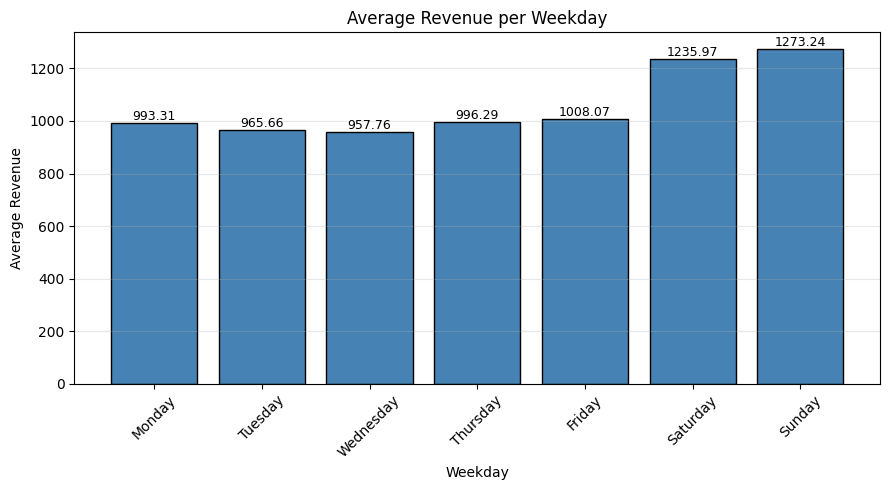

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# determine column names robustly
if 'merged_cleaned' not in globals():
    raise KeyError("DataFrame 'merged_cleaned' not found in the notebook namespace.")

revenue_col = 'Revenue' if 'Revenue' in merged_cleaned.columns else ('Umsatz' if 'Umsatz' in merged_cleaned.columns else None)
date_col = 'Date' if 'Date' in merged_cleaned.columns else ('Datum' if 'Datum' in merged_cleaned.columns else None)

if revenue_col is None:
    raise KeyError("Keine Spalte 'Umsatz' oder 'Revenue' in merged_cleaned gefunden.")
if date_col is None:
    raise KeyError("Keine Spalte 'Datum' oder 'Date' in merged_cleaned gefunden.")

# ensure date column is datetime
merged_cleaned[date_col] = pd.to_datetime(merged_cleaned[date_col])

# prepare aggregated data: average revenue per weekday (Mon-Sun)
df = merged_cleaned[[date_col, revenue_col]].copy()
df['weekday_num'] = df[date_col].dt.weekday  # Monday=0
df['weekday'] = df[date_col].dt.day_name()

avg_by_weekday = df.groupby(['weekday_num', 'weekday'])[revenue_col].mean().reset_index()
avg_by_weekday = avg_by_weekday.sort_values('weekday_num')

# show table
print(avg_by_weekday[['weekday', revenue_col]].to_string(index=False))

# plot
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(avg_by_weekday['weekday'], avg_by_weekday[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Weekday')
ax.set_ylabel(f'Average {revenue_col}')
ax.set_title('Average Revenue per Weekday')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

# annotate values above bars
for bar, val in zip(bars, avg_by_weekday[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [91]:
print('Descriptive statistics for numeric variables')
print()
print('Revenue:\n',merged_cleaned["Revenue"].describe())
print()
print('Temperature:\n',merged_cleaned["Temperature"].describe())
print()
print('Cloud Cover:\n',merged_cleaned["CloudCover"].describe())
print()
print('Wind Speed:\n',merged_cleaned["WindSpeed"].describe())
print()
print('Descriptive statistics for categorical variables')
print()
print('Kiel Week:\n',merged_cleaned["KielWeek"].value_counts())
print()
print('School holidays:\n',merged_cleaned["holiday"].value_counts())
print()
print('Product Type:\n',sales["Warengruppe"].value_counts())

Descriptive statistics for numeric variables

Revenue:
 count    1807.000000
mean     1061.591270
std       290.666234
min       525.973832
25%       850.806263
50%      1002.464694
75%      1227.924258
max      3156.413344
Name: Revenue, dtype: float64

Temperature:
 count    1807.000000
mean       12.221052
std         7.275242
min        -8.475000
25%         6.312500
50%        12.125000
75%        18.125000
max        31.437500
Name: Temperature, dtype: float64

Cloud Cover:
 count    1807.000000
mean        4.688434
std         2.650726
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max         8.000000
Name: CloudCover, dtype: float64

Wind Speed:
 count    1807.000000
mean       11.008854
std         4.131012
min         3.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        35.000000
Name: WindSpeed, dtype: float64

Descriptive statistics for categorical variables

Kiel Week:
 KielWeek
0    1762
1      45
Name: c

Average Umsatz per Warengruppe:
product_name     Umsatz
     1=Bread 122.142509
     2=Roles 402.497911
 3=Croissant 163.340920
    4=Pastry  87.954042
     5=Cakes 276.795509
  6=Seasonal  66.916635


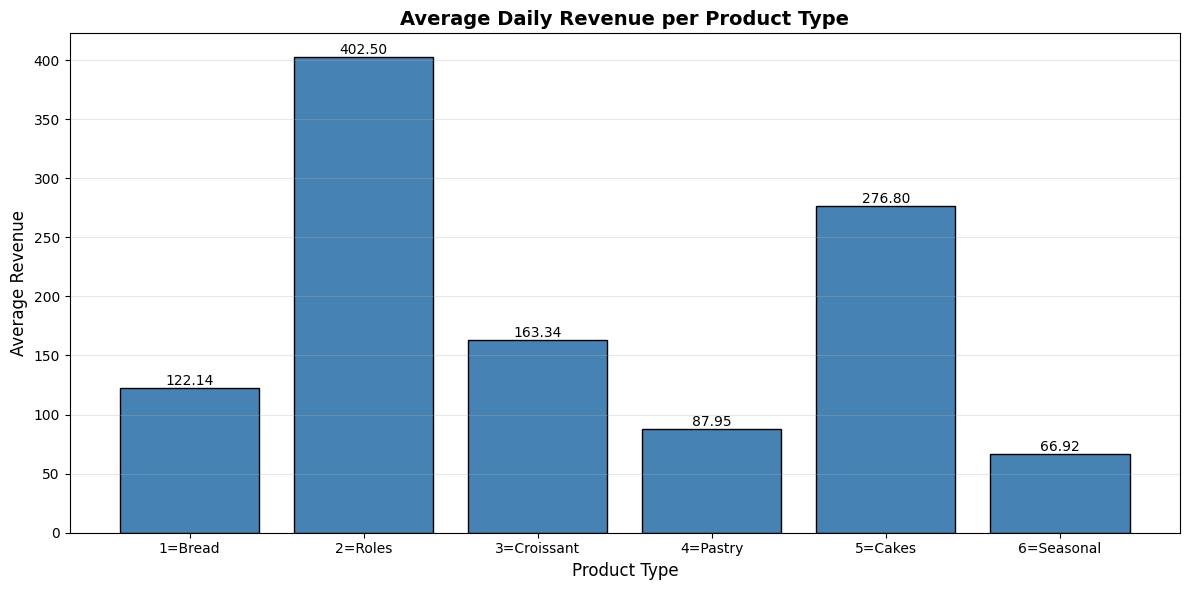

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# determine product column name
product_col = 'Warengruppe' if 'Warengruppe' in sales.columns else None
revenue_col = 'Umsatz' if 'Umsatz' in sales.columns else None

if product_col is None or revenue_col is None:
    raise KeyError("Spalten 'Warengruppe' oder 'Umsatz' nicht in sales DataFrame gefunden.")

# calculate average revenue per product type
avg_by_product = sales.groupby(product_col)[revenue_col].mean().reset_index()
avg_by_product = avg_by_product.sort_values(product_col)  # Sort by product type (1-6)

# create mapping for product names
product_mapping = {
    1: "1=Bread",
    2: "2=Roles",
    3: "3=Croissant",
    4: "4=Pastry",
    5: "5=Cakes",
    6: "6=Seasonal"
}

# map product codes to names
avg_by_product['product_name'] = avg_by_product[product_col].map(product_mapping)

# display table
print(f"Average {revenue_col} per {product_col}:")
print("=" * 50)
print(avg_by_product[['product_name', revenue_col]].to_string(index=False))

# create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(avg_by_product['product_name'], avg_by_product[revenue_col], color='steelblue', edgecolor='black')
ax.set_xlabel('Product Type', fontsize=12)
ax.set_ylabel('Average Revenue', fontsize=12)
ax.set_title(f'Average Daily Revenue per Product Type', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0, ha='center')

# annotate values above bars
for bar, val in zip(bars, avg_by_product[revenue_col]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{val:.2f}", 
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()